In [1]:
import collections
import os
import cPickle
import numpy as np
import pandas as pd
from functools import partial
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report, accuracy_score, label_ranking_loss
from sklearn.metrics import hamming_loss, label_ranking_average_precision_score, coverage_error
from sklearn.metrics import jaccard_similarity_score, f1_score
from scipy import sparse

import matplotlib.pyplot as plt
import nltk.data
from nltk.corpus import stopwords

%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def report_to_df(clfreport):
    lines = clfreport.split('\n')
    lines = filter(lambda l: not len(l.strip()) == 0, lines)

    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[0] == 'avg'
    cls_field_width = len(header) - len(header.lstrip())
    
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return [cls_name, precision, recall, fscore, support]

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        data[ret[0]] = ret[1:]
    data['Total/avg'] = parse_line(avg_line)[1:]
    df = pd.DataFrame.from_dict(data, orient = 'index')
    df.columns = ['precision', 'recall', 'f1-score', 'support']
    return df

In [3]:
# extract from the IMDB data with only 'genres' and 'plot'
cast_file_name = 'data/cast.pickle'
# extract from the IMDB data with only 'genres' and 'plot'
plot_file_name = 'data/plot.pickle'
# full TMDB data
tmdb_file_name = 'data/tmdb_info.pickle'

In [4]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [5]:
# load TMDB data
tmdb_movies = load_part(tmdb_file_name)

In [6]:
# load the IMDB cast data
cast_dict = load_part(cast_file_name)

In [7]:
# load the IMDB plot data
plot_dict = load_part(plot_file_name)

In [8]:
# prepare text features
text_dict = {}
for tmdb_id, imdb_movie in plot_dict.iteritems():
    d = tmdb_movies[tmdb_id].__dict__
    if (tmdb_id in tmdb_movies and 'plot' in imdb_movie and 'overview' in d and d['overview'] is not None):
        text_dict[tmdb_id] = imdb_movie['plot']
        text_dict[tmdb_id].append(d['overview'])
print 'Movies with text features :', len(text_dict)

Movies with text features : 37873


In [9]:
# prepare cast / crew features
crew_dict = {}
columns = [
    'director',
    'cast',
    'casting director',
    'miscellaneous crew',
    'original music',
    'producer',
    'cinematographer',
    'costume designer',
    'art direction']

for tmdb_id, imdb_movie in cast_dict.iteritems():
    d = tmdb_movies[tmdb_id].__dict__
    l = []
    for c in columns:
        if (c in imdb_movie):
            l = l + [c['name'].encode('utf-8') for c in imdb_movie[c]]
    # add crew and cast from TMDB
    if ('crew' in d):
        l = l + [c['name'].encode('utf-8') for c in d['crew']]
    if ('cast' in d):
        l = l + [c['name'].encode('utf-8') for c in d['cast']]
    crew_dict[tmdb_id] = '|'.join(set(l))
print 'Movies with cast/crew features :', len(crew_dict)

Movies with cast/crew features : 49015


In [10]:
# combine text and cast features
labels = []
cast_features = []
text_features = []
for tmdb_id, tmdb_movie in tmdb_movies.iteritems():
    d = tmdb_movie.__dict__
    if 'genres' not in d or d['genres'] is None:
        continue
    if tmdb_id not in crew_dict:
        continue
    if tmdb_id not in text_dict:
        continue
    labels.append([g['name'] for g in d['genres']])
    cast_features.append(crew_dict[tmdb_id])
    text_features.append(''.join(text_dict[tmdb_id]))
print 'Movies with all features :', len(labels)

Movies with all features : 37117


In [11]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
print y.shape

(37117L, 20L)


In [12]:
# split into test / train data
cast_F_train, cast_F_test, text_F_train, text_F_test, y_train, y_test =  train_test_split(
    cast_features, text_features, y, test_size=0.2, random_state=462)

In [13]:
text_vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("english"),
    token_pattern='[a-zA-Z]+[0-9]*',
    max_df=0.9,
    min_df=0.0001,
    dtype=np.float32,
)

text_X_train = text_vectorizer.fit_transform(text_F_train)
text_X_test = text_vectorizer.transform(text_F_test)

print np.shape(text_X_train)
print np.shape(text_X_test)

(29693, 32223)
(7424, 32223)


In [14]:
cast_vectorizer = CountVectorizer(
    max_df=0.99,
    min_df=0.0002,
    stop_words=stopwords.words("english"),
    tokenizer=lambda x: x.split('|'),
    dtype=np.float32)

cast_X_train = cast_vectorizer.fit_transform(cast_F_train)
cast_X_test = cast_vectorizer.transform(cast_F_test)

print np.shape(cast_X_train)
print np.shape(cast_X_test)

(29693, 34861)
(7424, 34861)


In [15]:
X_train = sparse.hstack((cast_X_train, text_X_train))
X_test = sparse.hstack((cast_X_test, text_X_test))

print np.shape(X_train)
print np.shape(X_test)

(29693, 67084)
(7424, 67084)


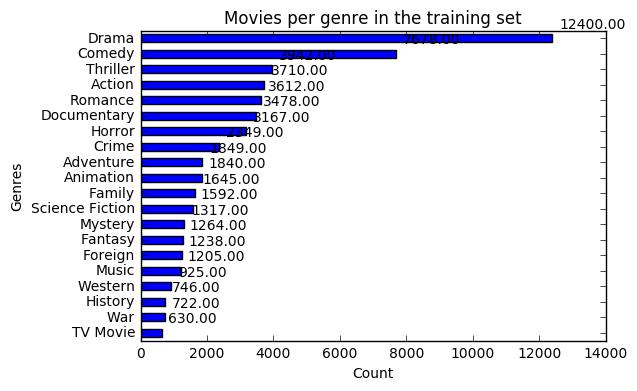

In [16]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

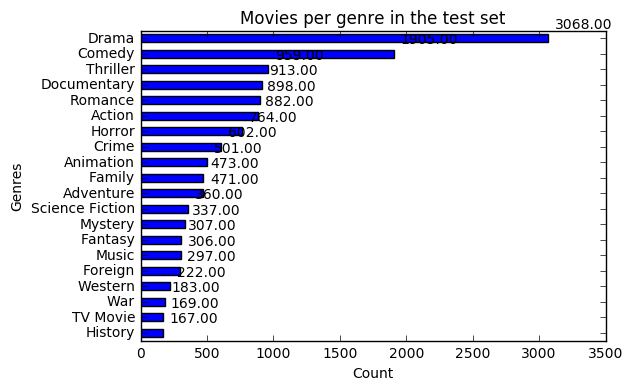

In [17]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

The Hamming loss is the fraction of labels that are incorrectly predicted.

In [23]:
def sgd(X_train, y_train):
    param_grid = {
        'estimator__loss': ('hinge', 'log'),
        'estimator__alpha' : np.logspace(-5, -1, num=50),
        'estimator__penalty' : ('l1', 'l2', 'elasticnet')}
    
    model = OneVsRestClassifier(SGDClassifier(class_weight='balanced', random_state=761, n_jobs = -1))
    model_tuning = GridSearchCV(
        model,
        param_grid = param_grid,
        scoring=make_scorer(hamming_loss, greater_is_better=False),
        cv=3,
        n_jobs=-1,
        verbose=1,
    )
    model_tuning.fit(X_train, y_train)
    return model_tuning

In [24]:
sgd_model = sgd(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 22.2min finished


In [25]:
y_train_pred = sgd_model.predict(X_train)
y_test_pred = sgd_model.predict(X_test)

train_report = classification_report(y_train, y_train_pred, target_names=mlb.classes_, digits=3)
test_report =  classification_report(y_test, y_test_pred, target_names=mlb.classes_, digits=3)

sgd_model_performance_df = report_to_df(test_report)

print sgd_model.best_params_
print 'hamming loss: %.3f' % hamming_loss(y_test, y_test_pred)
print 'Train performance: '
print train_report
print 'Test performance: '
print test_report

{'estimator__alpha': 0.002811768697974228, 'estimator__penalty': 'l2', 'estimator__loss': 'hinge'}
hamming loss: 0.081
Train performance: 
                 precision    recall  f1-score   support

         Action      0.736     0.749     0.742      3710
      Adventure      0.646     0.776     0.705      1849
      Animation      0.950     0.698     0.805      1840
         Comedy      0.860     0.580     0.693      7678
          Crime      0.681     0.792     0.733      2349
    Documentary      0.635     0.966     0.767      3478
          Drama      0.767     0.825     0.795     12400
         Family      0.627     0.832     0.715      1645
        Fantasy      0.613     0.794     0.692      1264
        Foreign      0.445     0.805     0.573      1238
        History      0.556     0.891     0.685       746
         Horror      0.711     0.895     0.792      3167
          Music      0.744     0.880     0.807      1205
        Mystery      0.671     0.801     0.730      1317
     

In [27]:
# save test classification report
with open('models/sgd_20_report.pickle', 'wb') as handle:
    cPickle.dump(test_report, handle, protocol = cPickle.HIGHEST_PROTOCOL)